# Libraries

In [1]:
from datetime import datetime
current_time = datetime.now()
print("Main Process Start date and time:", current_time)

Main Process Start date and time: 2024-11-03 21:49:15.611098


In [2]:
#!pip install imbalanced-learn

In [3]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import SMOTE
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix
import tensorflow as tf
from tensorflow.keras import layers, models

import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve

import seaborn as sns
from pylab import rcParams
#from matplotlib import pyplot as plt
%matplotlib inline
sns.set(style='whitegrid', palette='muted', font_scale=1.5)
rcParams['figure.figsize'] = 14, 8
RANDOM_SEED = 42
LABELS = ["Normal", "Fraud"]

# Load Dataset

## 1. Load the DS

In [4]:
# df = pd.read_csv("Kaggle-credit-card-fraud-detection_18Sep23/creditcard_2023.csv")
#df = pd.read_csv("Kaggle-credit-card-fraud-detection-US_13Jul24/creditcard.csv")
df = pd.read_csv("Kaggle-credit-card-fraud-detection_18Sep23/creditcard_2023.csv")


In [5]:
print(df.head())

   id        V1        V2        V3        V4        V5        V6        V7  \
0   0 -0.260648 -0.469648  2.496266 -0.083724  0.129681  0.732898  0.519014   
1   1  0.985100 -0.356045  0.558056 -0.429654  0.277140  0.428605  0.406466   
2   2 -0.260272 -0.949385  1.728538 -0.457986  0.074062  1.419481  0.743511   
3   3 -0.152152 -0.508959  1.746840 -1.090178  0.249486  1.143312  0.518269   
4   4 -0.206820 -0.165280  1.527053 -0.448293  0.106125  0.530549  0.658849   

         V8        V9  ...       V21       V22       V23       V24       V25  \
0 -0.130006  0.727159  ... -0.110552  0.217606 -0.134794  0.165959  0.126280   
1 -0.133118  0.347452  ... -0.194936 -0.605761  0.079469 -0.577395  0.190090   
2 -0.095576 -0.261297  ... -0.005020  0.702906  0.945045 -1.154666 -0.605564   
3 -0.065130 -0.205698  ... -0.146927 -0.038212 -0.214048 -1.893131  1.003963   
4 -0.212660  1.049921  ... -0.106984  0.729727 -0.161666  0.312561 -0.414116   

        V26       V27       V28    Amount  C

# Exploration

In [6]:
df.shape

(568630, 31)

In [7]:
df.isnull().values.any()

False

C:\Users\flyin\AppData\Local\Temp\ipykernel_45756\2107955042.py:1: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  count_classes = pd.value_counts(df['Class'], sort = True)


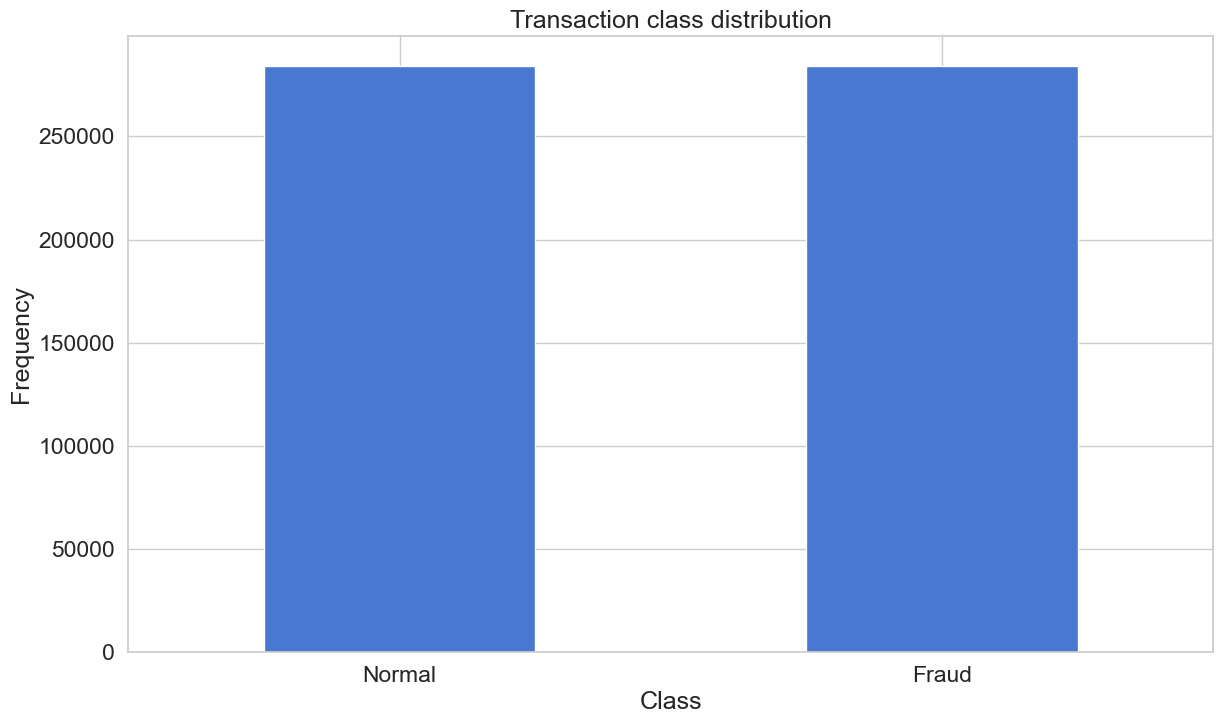

In [8]:
count_classes = pd.value_counts(df['Class'], sort = True)
count_classes.plot(kind = 'bar', rot=0)
plt.title("Transaction class distribution")
plt.xticks(range(2), LABELS)
plt.xlabel("Class")
plt.ylabel("Frequency");

We have a highly imbalanced dataset on our hands. Normal transactions overwhelm the fraudulent ones by a large margin. Let's look at the two types of transactions:

In [9]:
frauds = df[df.Class == 1]
normal = df[df.Class == 0]

In [10]:
print("frauds.shape:", frauds.shape)
print("normal.shape:", normal.shape)

frauds.shape: (284315, 31)
normal.shape: (284315, 31)


# Data Preprocessing

### 2. Separate features and labels

In [11]:
X = df.drop(['Class'], axis=1)  # 'Class' is the fraud label
y = df['Class']

In [12]:
print("X.shape:", X.shape)
print("y.shape:", y.shape)

X.shape: (568630, 30)
y.shape: (568630,)


### 3. Split the data into training and testing sets
### (Output: X_train, X_test, y_train, y_test)

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [14]:
print("X_train.shape:", X_train.shape)
print("X_test.shape:", X_test.shape)
print("y_train.shape:", y_train.shape)
print("y_test.shape:", y_test.shape)

X_train.shape: (454904, 30)
X_test.shape: (113726, 30)
y_train.shape: (454904,)
y_test.shape: (113726,)


# Handling Imbalanced Data with SMOTE

### 4. Handling Imbalanced Data with SMOTE
### (Output: X_train_sm, y_train_sm )

1. Over-sampling: SMOTE doesn't just duplicate existing minority class instances. Instead, it creates new synthetic samples by interpolating between existing minority class examples.
2. Synthetic Samples: For each instance in the minority class (fraud cases), SMOTE randomly selects one of its nearest neighbors and generates a synthetic point along the line connecting the two instances.

In [15]:
# Instantiate SMOTE
smote = SMOTE(random_state=RANDOM_SEED)

# Apply SMOTE to the training data
X_train_sm, y_train_sm = smote.fit_resample(X_train, y_train)

# Checking the distribution of the classes after resampling
print(f"Original training set class distribution:\n{y_train.value_counts()}")
print(f"Resampled training set class distribution:\n{y_train_sm.value_counts()}")

Original training set class distribution:
Class
0    227452
1    227452
Name: count, dtype: int64
Resampled training set class distribution:
Class
0    227452
1    227452
Name: count, dtype: int64


In [16]:
print("X_train_sm.shape:", X_train_sm.shape[1])
print("y_train_sm.shape:", y_train_sm.shape)

X_train_sm.shape: 30
y_train_sm.shape: (454904,)


### 5. Standardize the features after applying SMOTE
### (X_train_sm_scaled, X_test_scaled)

Feature scaling is applied using StandardScaler, which standardizes the features by removing the mean and scaling them to unit variance.

In [17]:
# Instantiate the StandardScaler
scaler = StandardScaler()

# Fit the scaler on the resampled training data and transform it
X_train_sm_scaled = scaler.fit_transform(X_train_sm)

# Transform the test data as well (but do NOT fit the scaler again)
X_test_scaled = scaler.transform(X_test)

# Check the scaled feature distributions (optional)
print(f"Mean of scaled training features:\n{np.mean(X_train_sm_scaled, axis=0)}")
print(f"Standard deviation of scaled training features:\n{np.std(X_train_sm_scaled, axis=0)}")

Mean of scaled training features:
[-2.94586022e-17 -1.96494812e-17 -1.68691890e-17 -1.07306785e-17
 -1.06525805e-17  1.65567966e-17  1.59320118e-18 -1.26675114e-17
  3.79556752e-18 -6.31032625e-18  9.37177166e-19  1.79625623e-19
  3.28792989e-17  5.21695289e-18  1.62444042e-17 -7.96600591e-18
 -1.64006004e-17 -2.40542139e-18 -1.88997395e-17 -5.51372566e-18
  4.31101496e-18  2.51475873e-18 -1.35578297e-17 -1.49948347e-18
 -1.21989228e-17 -8.66107897e-18 -1.52135093e-17 -6.15413006e-18
  5.06075670e-18  2.37933663e-16]
Standard deviation of scaled training features:
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1.]


# Unsupervised Learning with Autoencoder for Anomaly Detection

### 6. Unsupervised Learning with Autoencoder for Anomaly Detection
### (X_train_scaled2, X_test_scaled2)

Epoch 1/50
800/800 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.6104 - val_loss: 0.4876
Epoch 2/50
800/800 ━━━━━━━━━━━━━━━━━━━━ 1s 741us/step - loss: 0.4896 - val_loss: 0.4636
Epoch 3/50
800/800 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.4826 - val_loss: 0.4531
Epoch 4/50
800/800 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.4504 - val_loss: 0.4495
Epoch 5/50
800/800 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.4634 - val_loss: 0.4454
Epoch 6/50
800/800 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.4521 - val_loss: 0.4421
Epoch 7/50
800/800 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.4735 - val_loss: 0.4397
Epoch 8/50
800/800 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.4476 - val_loss: 0.4389
Epoch 9/50
800/800 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.4467 - val_loss: 0.4373
Epoch 10/50
800/800 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.4394 - val_loss: 0.4365
Epoch 11/50
800/800 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.4456 - val_loss: 0.4359
Epoch 12/50
800/800 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/st

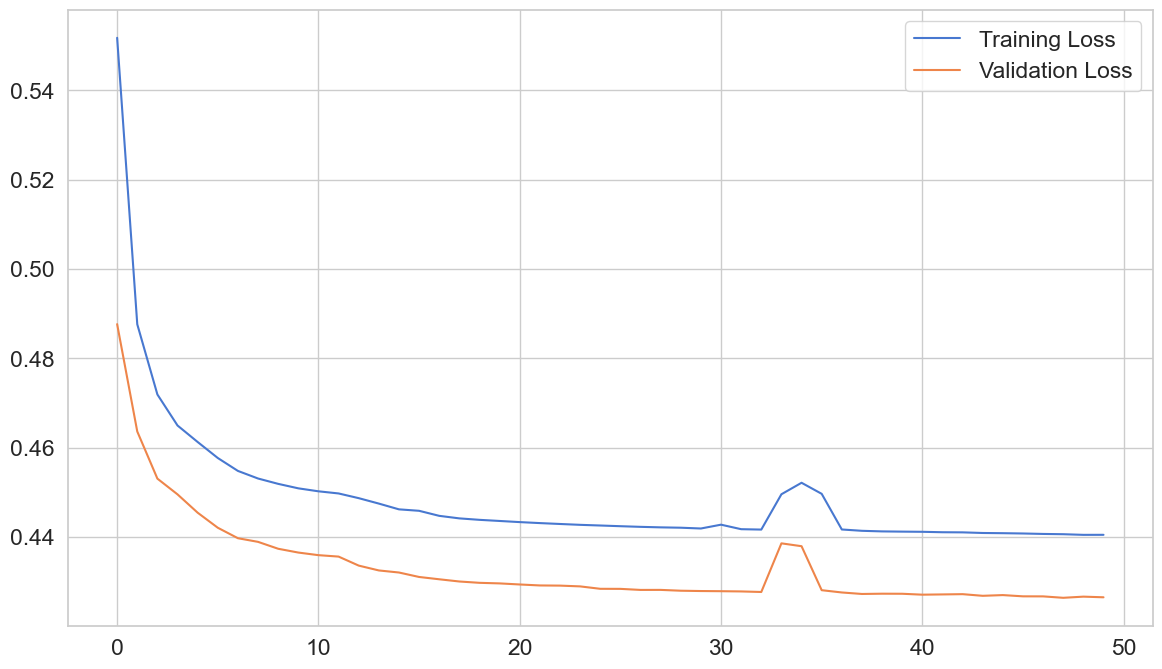

In [18]:
# 6. Unsupervised Learning with Autoencoder

# First, create a subset of the data with only normal transactions (Class 0) for training the autoencoder
X_train_autoencoder = X_train_sm_scaled[y_train_sm == 0]  # Only normal transactions for training the autoencoder

# Define the autoencoder model
autoencoder = models.Sequential([
    layers.Input(shape=(X_train_autoencoder.shape[1],)),
    layers.Dense(32, activation='relu'),
    layers.Dense(16, activation='relu'),
    layers.Dense(8, activation='relu'),  # Bottleneck layer (smallest representation)
    layers.Dense(16, activation='relu'),
    layers.Dense(32, activation='relu'),
    layers.Dense(X_train_autoencoder.shape[1], activation='sigmoid')  # Output layer
])

# Compile the model
autoencoder.compile(optimizer='adam', loss='mse')

# Train the autoencoder with normal data
history = autoencoder.fit(X_train_autoencoder, X_train_autoencoder,
                          epochs=50,
                          batch_size=256,
                          validation_split=0.1,
                          shuffle=True)

# Plot training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.show()


### 7. Generate reconstruction errors
### (reconstructed_data, mse, reconstructed_test_data, test_mse)

In [19]:
# Generate reconstruction errors for the training set
X_train_sm_pred = autoencoder.predict(X_train_sm_scaled)
train_reconstruction_errors = np.mean(np.square(X_train_sm_scaled - X_train_sm_pred), axis=1)

# Generate reconstruction errors for the test set
X_test_pred = autoencoder.predict(X_test_scaled)
test_reconstruction_errors = np.mean(np.square(X_test_scaled - X_test_pred), axis=1)

# Print the reconstruction error distributions (optional)
print(f"Reconstruction errors on the training set: {train_reconstruction_errors[:5]}")
print(f"Reconstruction errors on the test set: {test_reconstruction_errors[:5]}")

14216/14216 ━━━━━━━━━━━━━━━━━━━━ 7s 460us/step
3554/3554 ━━━━━━━━━━━━━━━━━━━━ 2s 479us/step
Reconstruction errors on the training set: [0.43442183 0.25170828 1.02460147 0.43217277 0.25450297]
Reconstruction errors on the test set: [0.35433106 0.41617612 0.200934   0.44051278 1.27554616]


### 8. Add the reconstruction error as a feature to the original dataset
### (X_train_sm_with_errors_df, X_test_with_errors_df)

In [20]:
# Add the reconstruction error to the training set
X_train_sm_with_errors = np.c_[X_train_sm_scaled, train_reconstruction_errors]

# Add the reconstruction error to the test set
X_test_with_errors = np.c_[X_test_scaled, test_reconstruction_errors]

# Convert back to a DataFrame for clarity (optional)
X_train_sm_with_errors_df = pd.DataFrame(X_train_sm_with_errors)
X_test_with_errors_df = pd.DataFrame(X_test_with_errors)

# Add column names (optional)
feature_names = [f"feature_{i}" for i in range(X_train_sm_scaled.shape[1])]
feature_names.append("reconstruction_error")
X_train_sm_with_errors_df.columns = feature_names
X_test_with_errors_df.columns = feature_names

# Check the new dataset (optional)
print(X_train_sm_with_errors_df.head())

   feature_0  feature_1  feature_2  feature_3  feature_4  feature_5  \
0  -0.356497  -0.449359   0.022698   0.037920  -1.324642   0.588570   
1  -0.794346   1.668580  -0.638618   0.544217  -0.456429  -0.034659   
2   1.103611   0.032322   0.406244  -0.724110   0.684640  -0.411775   
3  -0.048941  -0.053868  -0.141452   0.251407  -1.177533   0.618193   
4  -0.490956   1.586753  -0.874189  -0.020836  -1.022085   0.080529   

   feature_6  feature_7  feature_8  feature_9  ...  feature_21  feature_22  \
0   0.372863   0.636246  -0.091875   1.419651  ...   -0.359143   -0.772060   
1   0.540762   0.104395  -0.113459   2.512944  ...   -0.137031    0.039450   
2  -0.986649  -0.571462   0.173308   0.030681  ...    0.174227   -0.135215   
3   0.978237   0.510163   0.066254   0.485411  ...   -0.174592   -0.397942   
4   0.466920   0.176940  -0.138521   0.349567  ...    0.036702    0.679887   

   feature_23  feature_24  feature_25  feature_26  feature_27  feature_28  \
0    0.289799   -2.352699  

# Unsupervised Learning with KMeans Clustering

### 9. Converted column names to strings to avoid issues with KMeans.
### (X_train_sm_with_errors_df, X_test_with_errors_df)

In [21]:
# Convert column names to strings (if they are not already)
X_train_sm_with_errors_df.columns = X_train_sm_with_errors_df.columns.map(str)
X_test_with_errors_df.columns = X_test_with_errors_df.columns.map(str)

# Verify column names are strings (optional)
print(X_train_sm_with_errors_df.columns)

Index(['feature_0', 'feature_1', 'feature_2', 'feature_3', 'feature_4',
       'feature_5', 'feature_6', 'feature_7', 'feature_8', 'feature_9',
       'feature_10', 'feature_11', 'feature_12', 'feature_13', 'feature_14',
       'feature_15', 'feature_16', 'feature_17', 'feature_18', 'feature_19',
       'feature_20', 'feature_21', 'feature_22', 'feature_23', 'feature_24',
       'feature_25', 'feature_26', 'feature_27', 'feature_28', 'feature_29',
       'reconstruction_error'],
      dtype='object')


### 10. Generate the cluster labels as features
### (train_cluster_labels, test_cluster_labels)

In [22]:
# Instantiate KMeans with a chosen number of clusters (tunable parameter)
kmeans = KMeans(n_clusters=2, random_state=RANDOM_SEED)

# Fit KMeans on the training set with reconstruction errors
kmeans.fit(X_train_sm_with_errors_df)

# Generate cluster labels for the training and test sets
train_cluster_labels = kmeans.predict(X_train_sm_with_errors_df)
test_cluster_labels = kmeans.predict(X_test_with_errors_df)

# Check the first few cluster labels (optional)
print(f"Cluster labels for training set: {train_cluster_labels[:5]}")
print(f"Cluster labels for test set: {test_cluster_labels[:5]}")


Cluster labels for training set: [0 0 1 0 0]
Cluster labels for test set: [0 0 0 0 1]


### 11 Added these cluster labels as a new feature to both the training and test datasets.
### Output: (X_train_final_df, X_test_final_df)

In [23]:
# Add cluster labels to the training set
X_train_final = np.c_[X_train_sm_with_errors_df, train_cluster_labels]

# Add cluster labels to the test set
X_test_final = np.c_[X_test_with_errors_df, test_cluster_labels]

# Convert back to DataFrames for clarity (optional)
X_train_final_df = pd.DataFrame(X_train_final)
X_test_final_df = pd.DataFrame(X_test_final)

# Add column names for the new cluster feature
X_train_final_df.columns = list(X_train_sm_with_errors_df.columns) + ['cluster_label']
X_test_final_df.columns = list(X_test_with_errors_df.columns) + ['cluster_label']

# Check the final datasets (optional)
print(X_train_final_df.head())
print(X_test_final_df.head())

   feature_0  feature_1  feature_2  feature_3  feature_4  feature_5  \
0  -0.356497  -0.449359   0.022698   0.037920  -1.324642   0.588570   
1  -0.794346   1.668580  -0.638618   0.544217  -0.456429  -0.034659   
2   1.103611   0.032322   0.406244  -0.724110   0.684640  -0.411775   
3  -0.048941  -0.053868  -0.141452   0.251407  -1.177533   0.618193   
4  -0.490956   1.586753  -0.874189  -0.020836  -1.022085   0.080529   

   feature_6  feature_7  feature_8  feature_9  ...  feature_22  feature_23  \
0   0.372863   0.636246  -0.091875   1.419651  ...   -0.772060    0.289799   
1   0.540762   0.104395  -0.113459   2.512944  ...    0.039450    0.272799   
2  -0.986649  -0.571462   0.173308   0.030681  ...   -0.135215    0.478387   
3   0.978237   0.510163   0.066254   0.485411  ...   -0.397942    0.131723   
4   0.466920   0.176940  -0.138521   0.349567  ...    0.679887   -0.066060   

   feature_24  feature_25  feature_26  feature_27  feature_28  feature_29  \
0   -2.352699   -0.089708  

# Supervised Learning using Deep learning model

### 12. Supervised Learning using Deep learning model

Epoch 1/50


C:\Installed\Python_3.12\Lib\site-packages\keras\src\layers\core\input_layer.py:25: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


1422/1422 ━━━━━━━━━━━━━━━━━━━━ 2s 995us/step - accuracy: 0.9761 - loss: 0.0670 - val_accuracy: 0.9994 - val_loss: 0.0034
Epoch 2/50
1422/1422 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.9992 - loss: 0.0041 - val_accuracy: 0.9995 - val_loss: 0.0022
Epoch 3/50
1422/1422 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.9995 - loss: 0.0026 - val_accuracy: 0.9997 - val_loss: 0.0015
Epoch 4/50
1422/1422 ━━━━━━━━━━━━━━━━━━━━ 1s 822us/step - accuracy: 0.9996 - loss: 0.0020 - val_accuracy: 0.9997 - val_loss: 0.0014
Epoch 5/50
1422/1422 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.9996 - loss: 0.0015 - val_accuracy: 0.9998 - val_loss: 0.0011
Epoch 6/50
1422/1422 ━━━━━━━━━━━━━━━━━━━━ 2s 1000us/step - accuracy: 0.9996 - loss: 0.0015 - val_accuracy: 0.9997 - val_loss: 0.0012
Epoch 7/50
1422/1422 ━━━━━━━━━━━━━━━━━━━━ 1s 943us/step - accuracy: 0.9997 - loss: 0.0012 - val_accuracy: 0.9997 - val_loss: 0.0011
Epoch 8/50
1422/1422 ━━━━━━━━━━━━━━━━━━━━ 1s 755us/step - accuracy: 0.9997 - loss: 0.0012 - 

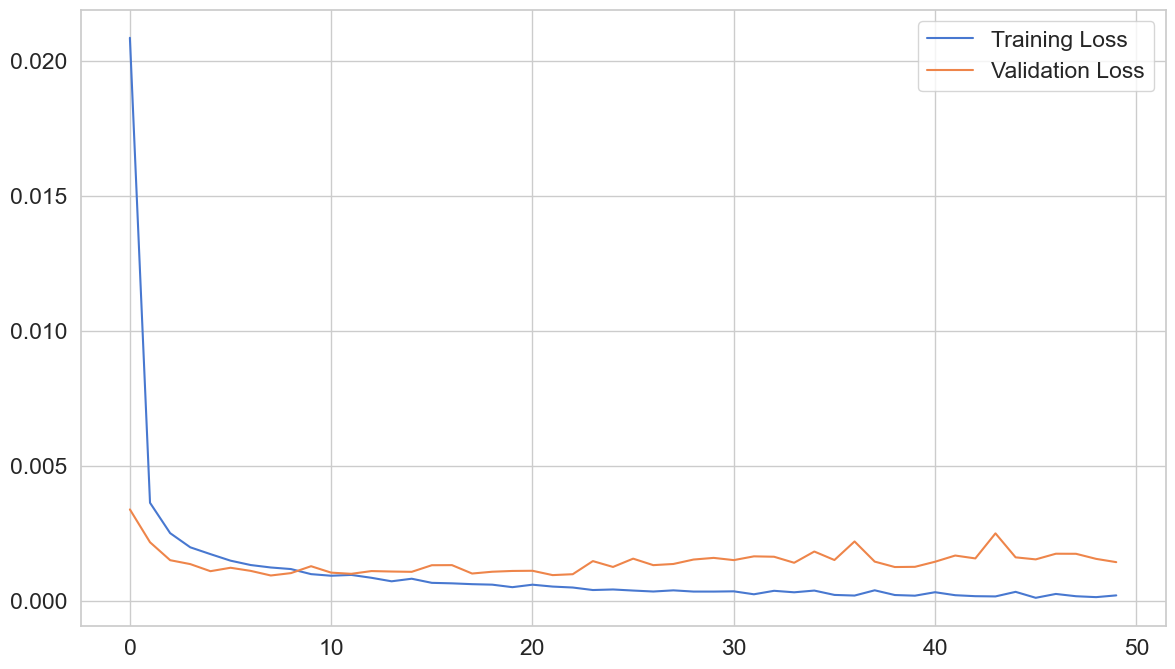

In [24]:
# Define the deep learning model
model = models.Sequential([
    layers.InputLayer(input_shape=(X_train_final_df.shape[1],)),  # Input size is number of features
    layers.Dense(64, activation='relu'),
    layers.Dense(32, activation='relu'),
    layers.Dense(1, activation='sigmoid')  # Output layer for binary classification
])

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(X_train_final_df, 
                    y_train_sm, 
                    epochs=50, 
                    batch_size=256,
                    validation_split=0.2)

# Plot training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.show()


### 13. Make predictions

In [25]:
# 13. Make predictions

# Make predictions on the test set
y_test_pred = model.predict(X_test_final_df)

# Convert predicted probabilities to binary labels (0 or 1)
y_test_pred_labels = (y_test_pred > 0.5).astype(int)

# Check predictions (optional)
print(f"First 5 predictions: {y_test_pred_labels[:5]}")


3554/3554 ━━━━━━━━━━━━━━━━━━━━ 2s 511us/step
First 5 predictions: [[1]
 [1]
 [0]
 [0]
 [1]]


### 14. Model evaluation

In [26]:
# Classification report
print("Classification Report:")
print(classification_report(y_test, y_test_pred_labels))

# Confusion matrix
conf_matrix = confusion_matrix(y_test, y_test_pred_labels)
print("Confusion Matrix:")
print(conf_matrix)

# ROC-AUC score
roc_auc = roc_auc_score(y_test, y_test_pred)
print(f"ROC-AUC Score: {roc_auc}")

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56863
           1       1.00      1.00      1.00     56863

    accuracy                           1.00    113726
   macro avg       1.00      1.00      1.00    113726
weighted avg       1.00      1.00      1.00    113726

Confusion Matrix:
[[56843    20]
 [   23 56840]]
ROC-AUC Score: 0.999965375309775


### 15. Plotting the ROC Curve (Optional)

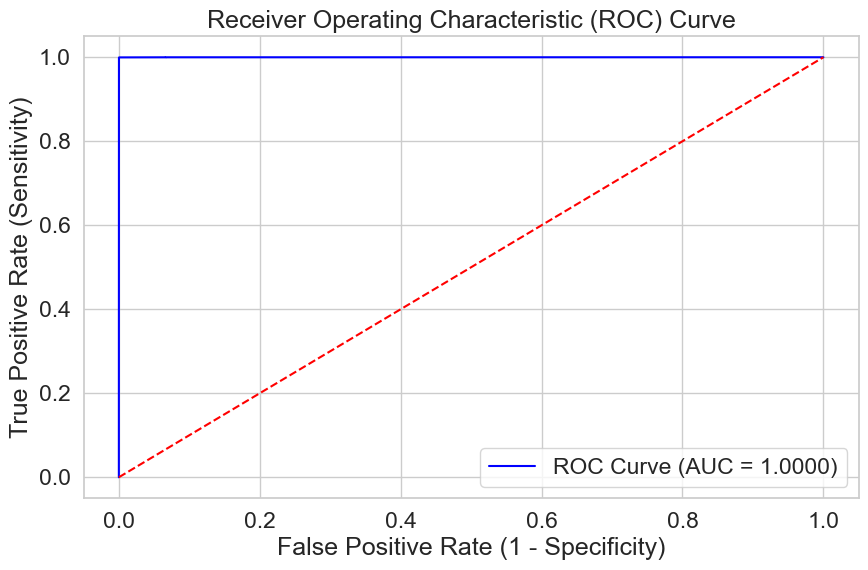

In [27]:
# Generate ROC curve values
fpr, tpr, thresholds = roc_curve(y_test, y_test_pred)

# Plot the ROC curve
plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, color='blue', label=f"ROC Curve (AUC = {roc_auc:.4f})")
plt.plot([0, 1], [0, 1], color='red', linestyle='--')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.legend(loc="lower right")
plt.show()

### 16. Evaluate the model using classification metrics

In [28]:
# Classification report
print("Classification Report:")
print(classification_report(y_test, y_test_pred_labels))

# Example output of classification report will include:
# - Precision: The ability of the classifier not to label as positive a sample that is actually negative.
# - Recall (Sensitivity): The ability of the classifier to find all the positive samples.
# - F1-score: The weighted harmonic mean of precision and recall.
# - Support: The number of occurrences of each class in the true data.

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56863
           1       1.00      1.00      1.00     56863

    accuracy                           1.00    113726
   macro avg       1.00      1.00      1.00    113726
weighted avg       1.00      1.00      1.00    113726



### 17. ROC AUC Score

In [29]:
# ROC-AUC score
roc_auc = roc_auc_score(y_test, y_test_pred)
print(f"ROC-AUC Score: {roc_auc:.4f}")

ROC-AUC Score: 1.0000


### 18. Confusion Matrix

Confusion Matrix:
[[56843    20]
 [   23 56840]]


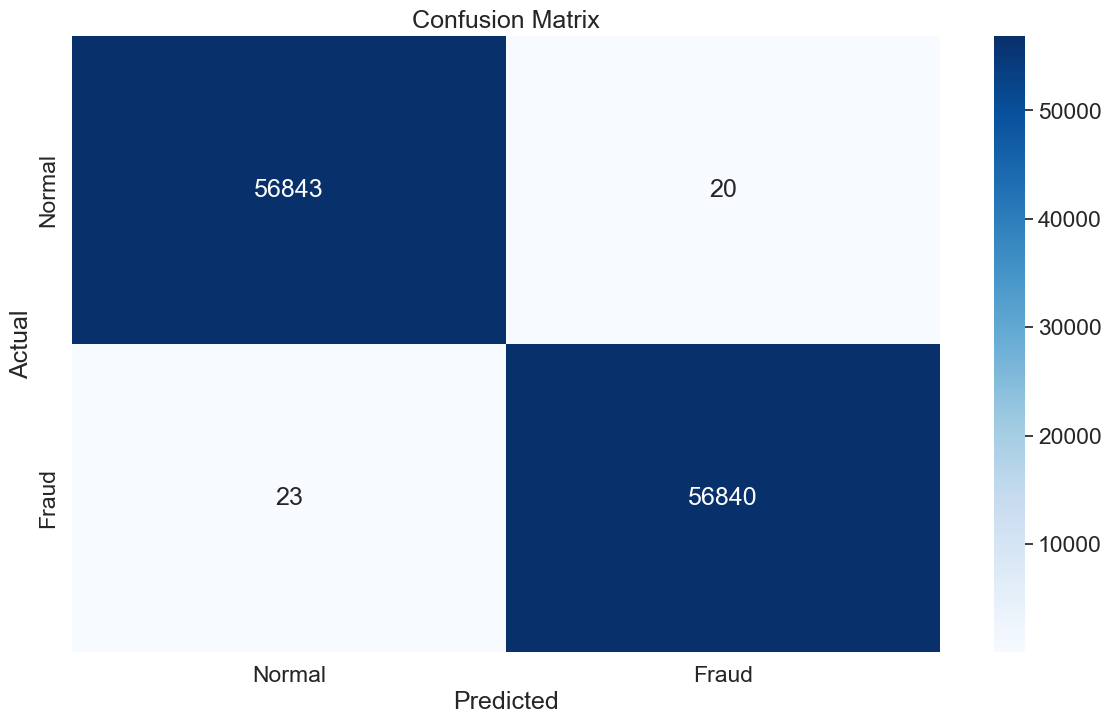

In [30]:
# Confusion matrix
conf_matrix = confusion_matrix(y_test, y_test_pred_labels)

# Print the confusion matrix
print("Confusion Matrix:")
print(conf_matrix)

# You can visualize the confusion matrix using seaborn for clarity
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=LABELS, yticklabels=LABELS)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [31]:
from datetime import datetime
current_time = datetime.now()
print("Main Process End date and time:", current_time)

Main Process End date and time: 2024-11-03 21:52:25.431424
